# Carbon Credit Projects in India: Data Preparation and Exploration

**Author:** Anvith  
**Date:** May 2025  
**Version:** 1.0

## Purpose
This notebook performs the initial data loading, cleaning, and preparation steps for analyzing both Clean Development Mechanism (CDM) and Verified Carbon Standard (VCS) projects in India. The analysis examines determinants of success in emission reduction performance by comparing actual versus estimated emission reductions.

## Input Data
- `vcs_projects_for_analysis.csv`: VCS projects dataset with success indicators
- `results_cdm.xlsx`: CDM projects dataset

## Output Files
- `vcs_processed.csv`: Processed VCS dataset with technology categories
- `cdm_processed.csv`: Processed CDM dataset with matching structure
- `combined_projects_categorized.csv`: Combined dataset for analysis

## Workflow
1. Load and process VCS data
2. Load and process CDM data
3. Standardize variables across both datasets
4. Combine datasets for unified analysis

## Dependencies
- pandas
- numpy
- matplotlib
- seaborn

In [64]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Set matplotlib to display plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create directories for outputs if they don't exist
os.makedirs('../output', exist_ok=True)
os.makedirs('../output/figures', exist_ok=True)
os.makedirs('../output/tables', exist_ok=True)

# Helper function for file paths
def get_path(file_name, directory=None):
    """
    Get standardized file path.
    
    Parameters:
    -----------
    file_name : str
        Name of the file
    directory : str or None
        Subdirectory (default: None, for root project directory)
        
    Returns:
    --------
    str
        Full file path
    """
    if directory is None:
        return file_name
    else:
        return os.path.join(directory, file_name)

# Progress tracking function
def log_progress(step, message):
    """Log progress with timestamp"""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {step}: {message}")

In [65]:
###################
# PARAMETERS
###################

# File paths
DATA_DIR = '../data'  # Parent directory containing input data
OUTPUT_DIR = '../output'  # Parent directory for output files
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
TABLES_DIR = os.path.join(OUTPUT_DIR, 'tables')

# Input and output files
VCS_INPUT_FILE = os.path.join(DATA_DIR, 'vcs_projects_for_analysis.csv')
CDM_INPUT_FILE = os.path.join(DATA_DIR, 'results_cdm.csv')
VCS_PROCESSED_FILE = os.path.join(OUTPUT_DIR, 'vcs_processed.csv')
CDM_PROCESSED_FILE = os.path.join(OUTPUT_DIR, 'cdm_processed.csv')
COMBINED_OUTPUT = os.path.join(OUTPUT_DIR, 'combined_projects_categorized.csv')

# Analysis parameters
BASE_TECH_CATEGORY = 'Wind'  # Base technology for regression
EMISSION_THRESHOLD = 60000  # Threshold for large-scale projects (tCO2e/year)

# Visualization settings
plt.style.use('seaborn-v0_8')  # Use compatible style
COLORS = sns.color_palette("viridis", 8)
sns.set_context("paper", font_scale=1.5)

## 1. VCS Data Processing

This section loads the VCS dataset and performs basic categorization.

In [66]:
# Load the VCS dataset
log_progress("VCS Data Loading", "Starting to load data")
df_vcs = pd.read_csv(VCS_INPUT_FILE)
log_progress("VCS Data Loading", f"Completed - loaded {len(df_vcs)} projects")

# Basic dataset information
print(f"VCS dataset contains {len(df_vcs)} projects with complete data")
print(f"Number of columns: {len(df_vcs.columns)}")
print("\nVCS Column names:")
for i, col in enumerate(df_vcs.columns):
    print(f"  {i}: {col}")

# Display first few rows
print("\nFirst 5 rows of VCS data:")
print(df_vcs.head())

# Summary statistics for key numeric columns
print("\nSummary statistics for key VCS metrics:")
numeric_cols = ['Estimated Annual Emission Reductions', 't_actual_years', 
                'Total_Actual_VCUs_Issued', 'q_quotient', 'log_q_success_indicator']
print(df_vcs[numeric_cols].describe())

# Add regime indicator
df_vcs['Regime'] = 'VCS'

# Create a function to categorize projects based on your data
def categorize_technology(row):
    """
    Categorize projects into key technology types based on Project Type and Methodology
    """
    project_type = str(row['Project Type']).lower()
    methodology = str(row['Methodology']).lower()
    
    # Wind projects
    if any(term in project_type for term in ['wind', 'eolic']):
        return 'Wind'
    
    # Hydro projects
    elif any(term in project_type for term in ['hydro', 'hydroelectric', 'hydropower']):
        return 'Hydro'
    
    # Solar projects
    elif any(term in project_type for term in ['solar', 'photovoltaic', 'pv']):
        return 'Solar'
    
    # Biomass and waste-to-energy projects
    elif any(term in project_type for term in ['biomass', 'biogas', 'landfill', 'methane', 'waste']):
        return 'Biomass and Waste'
    
    # Energy efficiency projects, including cookstoves
    elif any(term in project_type for term in ['efficiency', 'efficient', 'cookstove', 'cook stove', 'demand']):
        return 'Energy Efficiency'
    
    # HFC/Industrial gas projects (more common in CDM)
    elif any(term in project_type for term in ['hfc', 'industrial gas', 'n2o', 'pfc', 'sf6']):
        return 'Industrial Gases'
    
    # Use methodology as a fallback if project type is unclear
    elif 'ams-i' in methodology:  # Small-scale renewable energy
        return 'Other Renewable'
    elif 'ams-ii' in methodology:  # Small-scale energy efficiency
        return 'Energy Efficiency'
    elif 'ams-iii' in methodology:  # Small-scale other project activities
        return 'Other'
    elif 'acm000' in methodology:  # Large-scale consolidated methodologies
        return 'Other'
    
    # Default category
    else:
        return 'Other'

# Apply the technology categorization function to VCS data
df_vcs['Technology_Category'] = df_vcs.apply(categorize_technology, axis=1)

# Check the distribution of categories
tech_distribution_vcs = df_vcs['Technology_Category'].value_counts()
print("\nVCS Technology Categories:")
print(tech_distribution_vcs)

# Create dummy variables for regression (Wind as base category)
tech_dummies_vcs = pd.get_dummies(df_vcs['Technology_Category'], prefix='Tech')

# Check if base category exists before dropping
if f'Tech_{BASE_TECH_CATEGORY}' in tech_dummies_vcs.columns:
    tech_dummies_vcs = tech_dummies_vcs.drop(f'Tech_{BASE_TECH_CATEGORY}', axis=1)  # Wind as base category
    print(f"\nBase category for Technology: {BASE_TECH_CATEGORY}")
else:
    # If no Wind projects, use another category as base
    base_category = tech_distribution_vcs.index[0]  # Most common category
    tech_dummies_vcs = tech_dummies_vcs.drop(f'Tech_{base_category}', axis=1)
    print(f"\nBase category for Technology: {base_category}")

# Add dummy variables to the dataset
df_vcs = pd.concat([df_vcs, tech_dummies_vcs], axis=1)

# Determine scale for VCS projects
def determine_scale(row):
    """
    Determine if a project is small scale or large scale based on methodology and size
    """
    methodology = str(row['Methodology']).upper()
    emissions = row['Estimated Annual Emission Reductions']
    
    # Clear indicators from methodology
    if 'AMS-' in methodology:  # AMS = Small-scale
        return 'Small Scale'
    elif 'ACM' in methodology or 'AM' in methodology:  # ACM/AM = Large-scale
        return 'Large Scale'
    
    # Use emission size as fallback
    elif emissions > EMISSION_THRESHOLD:  # Common threshold
        return 'Large Scale'
    else:
        return 'Small Scale'

# Apply the scale determination function to VCS data
df_vcs['Scale_Category'] = df_vcs.apply(determine_scale, axis=1)

# Create a binary indicator for regression (Small Scale as base)
df_vcs['Scale_Large'] = df_vcs['Scale_Category'].apply(lambda x: 1 if x == 'Large Scale' else 0)

# Check the distribution of scale categories for VCS
scale_distribution_vcs = df_vcs['Scale_Category'].value_counts()
print("\nVCS Scale Categories:")
print(scale_distribution_vcs)

# Determine international participation for VCS projects
def has_international_participation(proponent):
    """
    Identify if a project likely has international participation based on proponent name
    """
    if pd.isna(proponent):
        return 0
    
    proponent = str(proponent).lower()
    
    # Keywords suggesting international entities
    int_keywords = [
        'gmbh', 'ltd', 'inc', 'international', 'global', 'europe', 'japan', 
        'usa', 'america', 'trading', 'capital', 'carbon', 'markets', 'ag', 
        'b.v.', 'holding', 'energy', 'investments', 'asset', 'management',
        'fund', 'green', 'climate', 'development', 'financing', 'switzerland',
        'uk', 'spain', 'germany', 'netherlands', 'france', 'denmark', 'sweden',
        'zurich', 'london', 'world', 'bank', 'corp', 'group'
    ]
    
    # Indian-specific terms that don't indicate international participation
    indian_terms = [
        'india', 'indian', 'limited', 'pvt', 'private', 'bharat', 'infra', 
        'power', 'maharashtra', 'gujarat', 'tamil', 'nadu', 'karnataka', 
        'pradesh', 'punjab', 'delhi', 'mumbai', 'bangalore', 'chennai', 
        'kolkata', 'hyderabad', 'renewables', 'energy', 'solar', 'wind'
    ]
    
    # Check for international keywords not also containing Indian terms
    for keyword in int_keywords:
        if keyword in proponent and not any(term in proponent for term in indian_terms):
            return 1
    
    # Special case: If it explicitly mentions partnership/joint venture
    if any(term in proponent for term in ['partnership', 'joint venture', 'collaboration']):
        return 1
    
    return 0

# Apply the international participation function to VCS data
df_vcs['Is_International'] = df_vcs['Proponent'].apply(has_international_participation)

# Check the distribution for VCS
int_distribution_vcs = df_vcs['Is_International'].value_counts()
print("\nVCS International Participation:")
print(int_distribution_vcs)
print(f"Percentage with international participation: {df_vcs['Is_International'].mean()*100:.1f}%")

# Save the processed VCS dataset
df_vcs.to_csv(VCS_PROCESSED_FILE, index=False)
log_progress("VCS Processing", f"Completed - saved to {VCS_PROCESSED_FILE}")

[2025-05-09 21:58:29] VCS Data Loading: Starting to load data
[2025-05-09 21:58:29] VCS Data Loading: Completed - loaded 293 projects
VCS dataset contains 293 projects with complete data
Number of columns: 21

VCS Column names:
  0: ID
  1: Name
  2: Proponent
  3: Project Type
  4: AFOLU Activities
  5: Methodology
  6: Status
  7: Country/Area
  8: Estimated Annual Emission Reductions
  9: Region
  10: Project Registration Date
  11: Crediting Period Start Date
  12: Crediting Period End Date
  13: Total_Actual_VCUs_Issued
  14: Actual_Issuance_Start_Date
  15: Actual_Issuance_End_Date
  16: t_actual_days
  17: t_actual_years
  18: Total_Estimated_ERs_Actual_Period
  19: q_quotient
  20: log_q_success_indicator

First 5 rows of VCS data:
     ID                                               Name  \
0  4493         Varanasi Smart City Bio-Conversion Project   
1  4413  Household Biogas Program for Smallholder Farme...   
2  4382         MSW to Compost through BSF Rearing process   
3 

## 2. CDM Data Processing

This section loads and processes the CDM dataset to match the VCS structure.

In [67]:
# Load the CDM dataset
log_progress("CDM Data Loading", "Starting to load data")
df_cdm_raw = pd.read_csv(CDM_INPUT_FILE)

log_progress("CDM Data Loading", f"Completed - loaded {len(df_cdm_raw)} projects")
df_cdm_raw.columns = df_cdm_raw.columns.str.strip()

# Basic dataset information
print(f"CDM dataset contains {len(df_cdm_raw)} projects")
print(f"Number of columns: {len(df_cdm_raw.columns)}")

# Display first few rows of critical columns
critical_columns = [
   'CDM project reference number',
   'Registration project title',
   'Project classification',
   'Methodologies used at registration',
   'Project type (UNEP DTU)',
   'Project subtype (UNEP DTU)',
   'Start of first crediting period',
   'End of first crediting period',
   'Amount Of Reductions (PDD ex-ante) per year in CP1 (PoA based on the sum of curr',
   'First issuance',
   'Lastest issuance',
   'Total CERs issued'
]

# Check if all critical columns exist
missing_cols = [col for col in critical_columns if col not in df_cdm_raw.columns]
if missing_cols:
   print(f"WARNING: Missing critical columns in CDM data: {missing_cols}")
else:
   print("All critical columns present in CDM data")

# Display sample of critical columns
print("\nSample CDM data (critical columns):")
sample_data = df_cdm_raw[critical_columns].head(3)
for col in critical_columns:
   print(f"\n{col}:")
   print(sample_data[col])

# Process CDM data to match VCS structure
log_progress("CDM Processing", "Standardizing CDM data structure")

# Create a new DataFrame for standardized CDM data
df_cdm = pd.DataFrame()

# Basic project information
df_cdm['ID'] = df_cdm_raw['CDM project reference number'].astype(str)
df_cdm['Name'] = df_cdm_raw['Registration project title']
df_cdm['Proponent'] = df_cdm_raw['DOE']  # Use DOE as a proxy for proponent
df_cdm['Project Type'] = (df_cdm_raw['Project type (UNEP DTU)'].fillna('') + ': ' + 
                         df_cdm_raw['Project subtype (UNEP DTU)'].fillna(''))
df_cdm['AFOLU Activities'] = np.nan  # Not typically relevant for CDM
df_cdm['Methodology'] = df_cdm_raw['Methodologies used at registration']
df_cdm['Status'] = df_cdm_raw['Website project status']
df_cdm['Country/Area'] = 'India'  # All projects are in India

# Clean and convert estimated emission reductions (handle commas and formatting)
emission_col = 'Amount Of Reductions (PDD ex-ante) per year in CP1 (PoA based on the sum of curr'
df_cdm['Estimated Annual Emission Reductions'] = df_cdm_raw[emission_col].astype(str).str.replace(',', '')
df_cdm['Estimated Annual Emission Reductions'] = pd.to_numeric(df_cdm['Estimated Annual Emission Reductions'], errors='coerce')

# Print sample of estimated reductions for debugging
print("\nSample of estimated annual emission reductions:")
print(df_cdm['Estimated Annual Emission Reductions'].head())

df_cdm['Region'] = 'ASP'  # Asia-Pacific region

# Date fields - convert to datetime with explicit format
# Use a function to try multiple date formats
def parse_date(date_str):
   """Try to parse date string with multiple formats"""
   if pd.isna(date_str):
       return pd.NaT
   
   date_str = str(date_str).strip()
   
   # Try different date formats
   formats = [
       '%d-%m-%y', '%d-%m-%Y',  # DD-MM-YY, DD-MM-YYYY
       '%Y-%m-%d',  # YYYY-MM-DD
       '%d/%m/%y', '%d/%m/%Y',  # DD/MM/YY, DD/MM/YYYY
       '%m-%d-%y', '%m-%d-%Y',  # MM-DD-YY, MM-DD-YYYY
       '%m/%d/%y', '%m/%d/%Y'   # MM/DD/YY, MM/DD/YYYY
   ]
   
   for fmt in formats:
       try:
           return pd.to_datetime(date_str, format=fmt)
       except:
           continue
   
   # If all explicit formats fail, try with dateutil parser
   try:
       return pd.to_datetime(date_str)
   except:
       return pd.NaT

# Apply date parsing
df_cdm['Project Registration Date'] = df_cdm_raw['Date of EB decision (see EB59 Annex 12, §25)'].apply(parse_date)
df_cdm['Crediting Period Start Date'] = df_cdm_raw['Start of first crediting period'].apply(parse_date)
df_cdm['Crediting Period End Date'] = df_cdm_raw['End of first crediting period'].apply(parse_date)

# Clean and convert actual issuance data
# Handle comma-separated numbers in 'Total CERs issued'
df_cdm['Total_Actual_VCUs_Issued'] = df_cdm_raw['Total CERs issued'].astype(str).str.replace(',', '')
df_cdm['Total_Actual_VCUs_Issued'] = pd.to_numeric(df_cdm['Total_Actual_VCUs_Issued'], errors='coerce')

# Print sample of actual issuance for debugging
print("\nSample of total actual CERs issued:")
print(df_cdm['Total_Actual_VCUs_Issued'].head())

# Parse issuance dates
df_cdm['Actual_Issuance_Start_Date'] = df_cdm_raw['First issuance'].apply(parse_date)
df_cdm['Actual_Issuance_End_Date'] = df_cdm_raw['Lastest issuance'].apply(parse_date)

# Print sample of issuance dates for debugging
print("\nSample of issuance dates:")
print(pd.DataFrame({
   'First': df_cdm['Actual_Issuance_Start_Date'].head(),
   'Last': df_cdm['Actual_Issuance_End_Date'].head()
}))

# Calculate actual days/years
# Only calculate for rows where both dates are available
valid_dates_mask = (df_cdm['Actual_Issuance_Start_Date'].notna() & 
                   df_cdm['Actual_Issuance_End_Date'].notna())

print(f"\nProjects with valid issuance dates: {valid_dates_mask.sum()} of {len(df_cdm)}")

# Initialize with NaN
df_cdm['t_actual_days'] = np.nan
df_cdm['t_actual_years'] = np.nan

# Calculate only for valid rows
df_cdm.loc[valid_dates_mask, 't_actual_days'] = (
   df_cdm.loc[valid_dates_mask, 'Actual_Issuance_End_Date'] - 
   df_cdm.loc[valid_dates_mask, 'Actual_Issuance_Start_Date']
).dt.days

# Filter for positive durations
positive_days_mask = df_cdm['t_actual_days'] > 0
df_cdm.loc[positive_days_mask, 't_actual_years'] = df_cdm.loc[positive_days_mask, 't_actual_days'] / 365.25

print(f"Projects with positive duration: {positive_days_mask.sum()} of {valid_dates_mask.sum()}")

# Calculate performance metrics
# Only calculate for rows with all required values
valid_metrics_mask = (
   df_cdm['Estimated Annual Emission Reductions'].notna() & 
   df_cdm['Total_Actual_VCUs_Issued'].notna() & 
   df_cdm['t_actual_years'].notna() & 
   (df_cdm['Estimated Annual Emission Reductions'] > 0) &
   (df_cdm['t_actual_years'] > 0)
)

print(f"\nProjects with all required values for metrics: {valid_metrics_mask.sum()} of {len(df_cdm)}")

# Initialize with NaN
df_cdm['Total_Estimated_ERs_Actual_Period'] = np.nan
df_cdm['q_quotient'] = np.nan
df_cdm['log_q_success_indicator'] = np.nan

# Calculate only for valid rows
df_cdm.loc[valid_metrics_mask, 'Total_Estimated_ERs_Actual_Period'] = (
   df_cdm.loc[valid_metrics_mask, 'Estimated Annual Emission Reductions'] * 
   df_cdm.loc[valid_metrics_mask, 't_actual_years']
)

df_cdm.loc[valid_metrics_mask, 'q_quotient'] = (
   df_cdm.loc[valid_metrics_mask, 'Total_Actual_VCUs_Issued'] / 
   df_cdm.loc[valid_metrics_mask, 'Total_Estimated_ERs_Actual_Period']
)

# Only calculate log for positive q_quotient
positive_q_mask = (df_cdm['q_quotient'] > 0)
df_cdm.loc[positive_q_mask, 'log_q_success_indicator'] = np.log(df_cdm.loc[positive_q_mask, 'q_quotient'])

print(f"Projects with valid success indicators: {df_cdm['log_q_success_indicator'].notna().sum()} of {len(df_cdm)}")

# Print distribution of success indicators for debugging
valid_log_q = df_cdm['log_q_success_indicator'].dropna()
if len(valid_log_q) > 0:
   print("\nDistribution of log_q_success_indicator for CDM projects:")
   print(valid_log_q.describe())

# Add regime indicator
df_cdm['Regime'] = 'CDM'

# Apply technology categorization function to CDM data
df_cdm['Technology_Category'] = df_cdm.apply(categorize_technology, axis=1)

# Check the distribution of categories for CDM
tech_distribution_cdm = df_cdm['Technology_Category'].value_counts()
print("\nCDM Technology Categories:")
print(tech_distribution_cdm)

# Create dummy variables for regression
tech_dummies_cdm = pd.get_dummies(df_cdm['Technology_Category'], prefix='Tech')
if f'Tech_{BASE_TECH_CATEGORY}' in tech_dummies_cdm.columns:
   tech_dummies_cdm = tech_dummies_cdm.drop(f'Tech_{BASE_TECH_CATEGORY}', axis=1)  # Wind as base
df_cdm = pd.concat([df_cdm, tech_dummies_cdm], axis=1)

# Determine scale for CDM projects (based on project classification)
df_cdm['Scale_Category'] = df_cdm_raw['Project classification'].fillna('SMALL')
df_cdm['Scale_Large'] = df_cdm['Scale_Category'].str.upper().eq('LARGE').astype(int)

# Check the scale distribution for CDM
scale_distribution_cdm = df_cdm['Scale_Category'].value_counts()
print("\nCDM Scale Categories:")
print(scale_distribution_cdm)

# For CDM, all projects involve international participation through the CDM framework
df_cdm['Is_International'] = 1

# Check missing values in key fields
missing_vals_cdm = df_cdm[['log_q_success_indicator', 't_actual_years', 'Total_Actual_VCUs_Issued']].isnull().sum()
print("\nMissing values in key CDM columns:")
print(missing_vals_cdm)

# Filter for CDM projects with valid success indicators
df_cdm_valid = df_cdm.dropna(subset=['log_q_success_indicator'])
print(f"\nCDM projects with valid success indicators: {len(df_cdm_valid)} of {len(df_cdm)}")

# Save the processed CDM dataset
df_cdm.to_csv(CDM_PROCESSED_FILE, index=False)
log_progress("CDM Processing", f"Completed - saved to {CDM_PROCESSED_FILE}")

[2025-05-09 21:58:29] CDM Data Loading: Starting to load data
[2025-05-09 21:58:29] CDM Data Loading: Completed - loaded 1685 projects
CDM dataset contains 1685 projects
Number of columns: 65
All critical columns present in CDM data

Sample CDM data (critical columns):

CDM project reference number:
0     1
1    35
2    58
Name: CDM project reference number, dtype: int64

Registration project title:
0    Project for GHG emission reduction by thermal ...
1    5 MW Dehar Grid-connected SHP in Himachal Prad...
2    Biomass in Rajasthan - Electricity generation ...
Name: Registration project title, dtype: object

Project classification:
0    LARGE
1    SMALL
2    SMALL
Name: Project classification, dtype: object

Methodologies used at registration:
0       AM0001 2.0
1    AMS-I.D. 11.0
2    AMS-I.D. 11.0
Name: Methodologies used at registration, dtype: object

Project type (UNEP DTU):
0              HFCs
1             Hydro
2    Biomass Energy
Name: Project type (UNEP DTU), dtype: object



## 3. Combined Dataset Creation

This section combines the processed VCS and CDM datasets for unified analysis.

[2025-05-09 21:58:30] Data Combination: Combining VCS and CDM datasets
Combined dataset contains 1978 projects
  VCS projects: 293
  CDM projects: 1685

Missing values in key columns of combined dataset:
log_q_success_indicator    1186
t_actual_years             1186
Regime                        0
dtype: int64

Projects with valid success indicators: 792 of 1978
  VCS projects: 293
  CDM projects: 499

Success indicator by regime:
        count      mean    median       std
Regime                                     
CDM       499  0.084419  0.006993  0.753000
VCS       293 -0.605954 -0.187572  1.676474
[2025-05-09 21:58:30] Data Combination: Saved combined dataset with 1978 projects


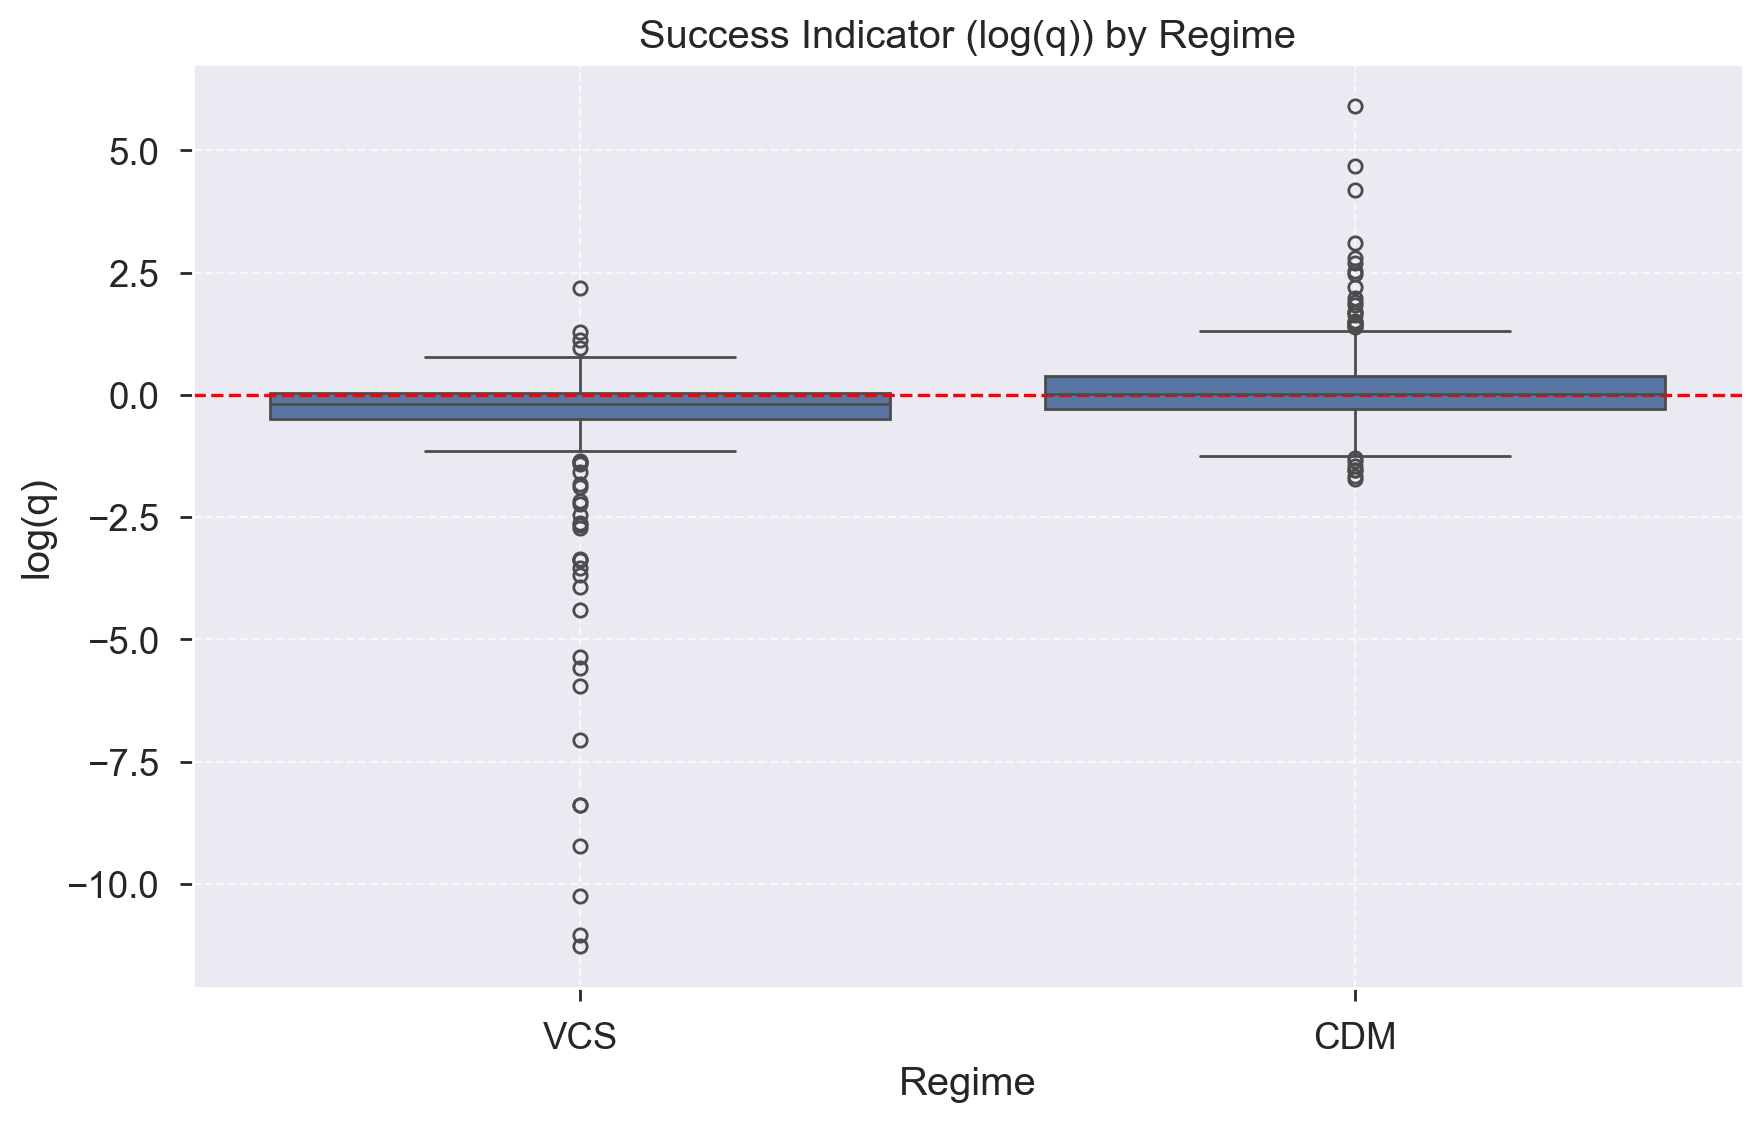

<Figure size 1200x800 with 0 Axes>

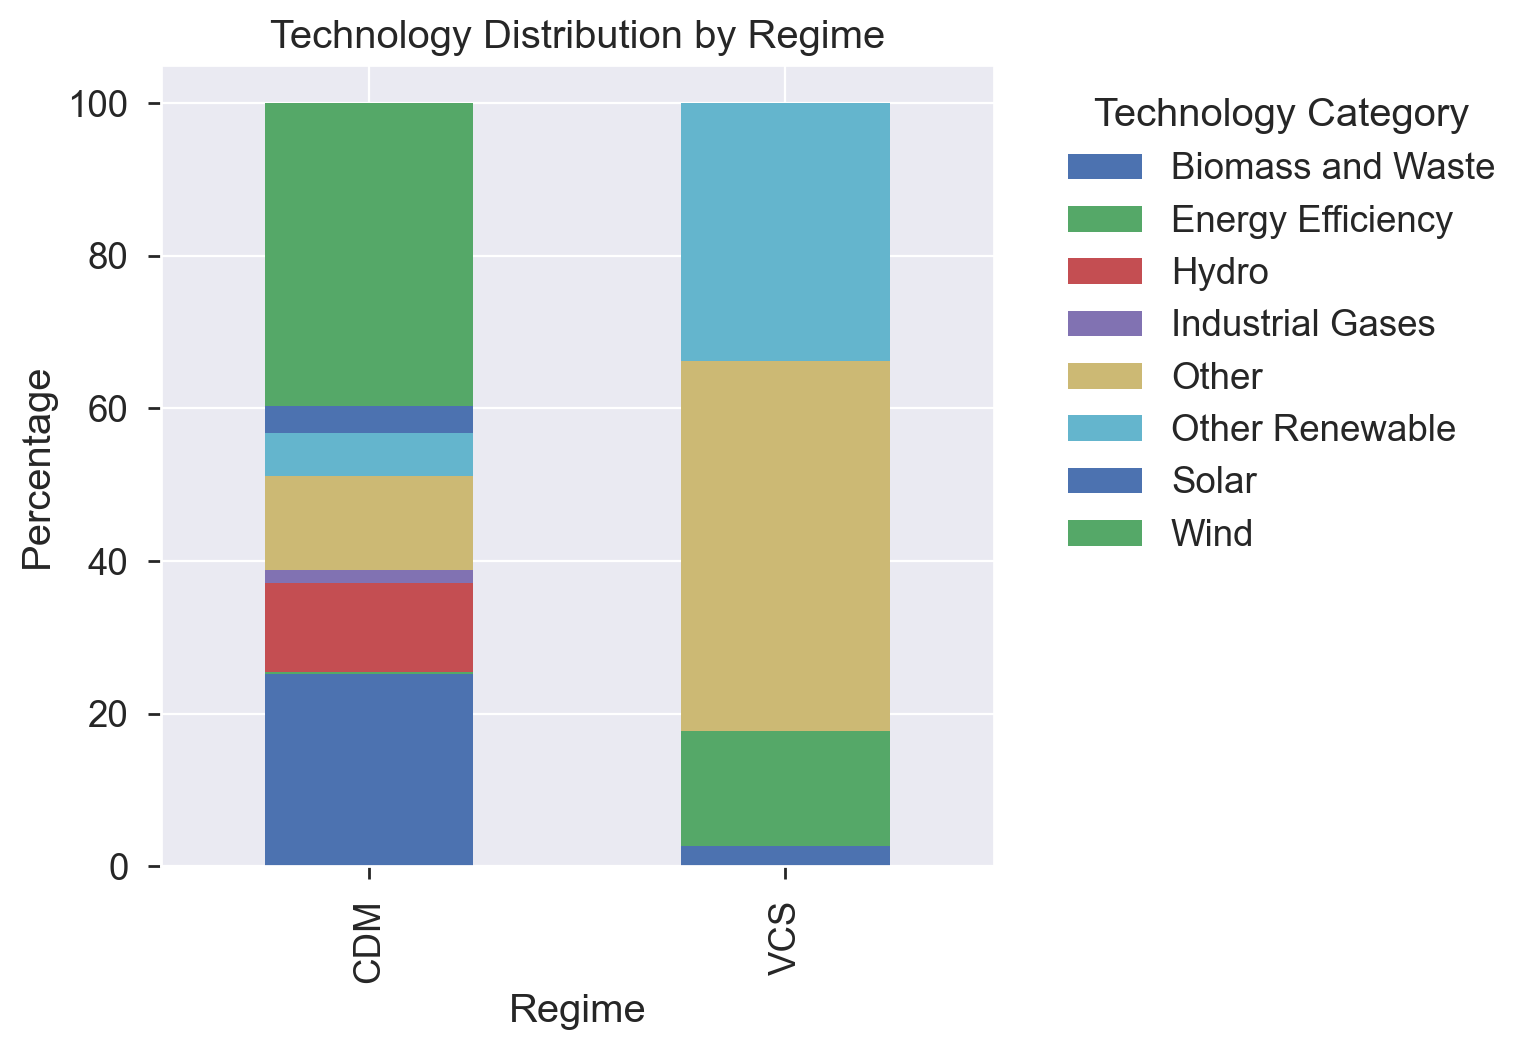

<Figure size 1000x600 with 0 Axes>

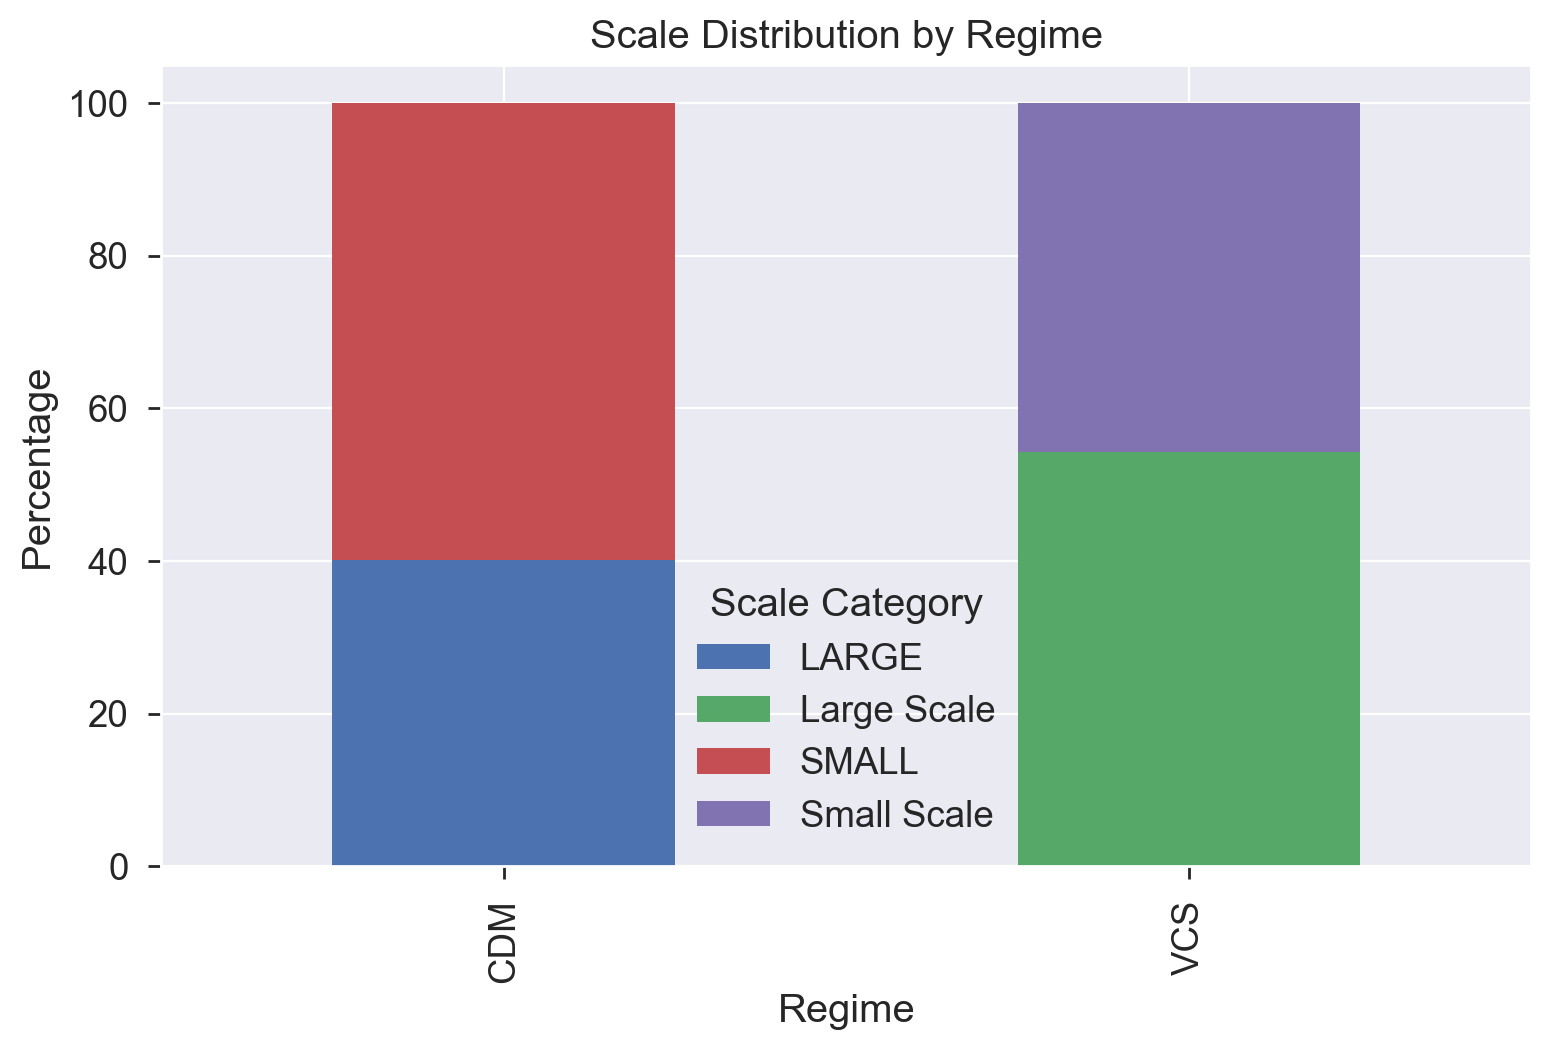

In [68]:
# Combine VCS and CDM datasets
log_progress("Data Combination", "Combining VCS and CDM datasets")

# Create combined dataset
df_combined = pd.concat([df_vcs, df_cdm], ignore_index=True)

# Check the combined dataset
print(f"Combined dataset contains {len(df_combined)} projects")
print(f"  VCS projects: {(df_combined['Regime'] == 'VCS').sum()}")
print(f"  CDM projects: {(df_combined['Regime'] == 'CDM').sum()}")

# Check for missing values in key columns
missing_vals_combined = df_combined[['log_q_success_indicator', 't_actual_years', 'Regime']].isnull().sum()
print("\nMissing values in key columns of combined dataset:")
print(missing_vals_combined)

# Create a variable to indicate CDM projects (for regression)
df_combined['Is_CDM'] = (df_combined['Regime'] == 'CDM').astype(int)

# Filter for projects with valid success indicators
df_combined_valid = df_combined.dropna(subset=['log_q_success_indicator'])
print(f"\nProjects with valid success indicators: {len(df_combined_valid)} of {len(df_combined)}")
print(f"  VCS projects: {(df_combined_valid['Regime'] == 'VCS').sum()}")
print(f"  CDM projects: {(df_combined_valid['Regime'] == 'CDM').sum()}")

# Compare success indicators between regimes
success_by_regime = df_combined_valid.groupby('Regime')['log_q_success_indicator'].agg(['count', 'mean', 'median', 'std'])
print("\nSuccess indicator by regime:")
print(success_by_regime)

# Save the combined dataset
df_combined.to_csv(COMBINED_OUTPUT, index=False)
log_progress("Data Combination", f"Saved combined dataset with {len(df_combined)} projects")

# Create visualizations comparing regimes
plt.figure(figsize=(10, 6))
sns.boxplot(x='Regime', y='log_q_success_indicator', data=df_combined_valid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Success Indicator (log(q)) by Regime')
plt.xlabel('Regime')
plt.ylabel('log(q)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(FIGURES_DIR, 'success_by_regime.png'), dpi=300)

# Technology distribution by regime
tech_by_regime = pd.crosstab(df_combined_valid['Regime'], df_combined_valid['Technology_Category'])
tech_by_regime_pct = tech_by_regime.div(tech_by_regime.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
tech_by_regime_pct.plot(kind='bar', stacked=True)
plt.title('Technology Distribution by Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage')
plt.legend(title='Technology Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'technology_by_regime.png'), dpi=300)

# Scale distribution by regime
scale_by_regime = pd.crosstab(df_combined_valid['Regime'], df_combined_valid['Scale_Category'])
scale_by_regime_pct = scale_by_regime.div(scale_by_regime.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
scale_by_regime_pct.plot(kind='bar', stacked=True)
plt.title('Scale Distribution by Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage')
plt.legend(title='Scale Category')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'scale_by_regime.png'), dpi=300)

## Summary of Outcomes

This notebook has successfully:

1. **Processed VCS Data**: Loaded and categorized VCS projects from India
2. **Processed CDM Data**: Standardized CDM project data to match VCS structure
3. **Created Technology Categories**: Applied consistent technology classification across both regimes
4. **Added Scale Variables**: Identified small vs. large scale projects
5. **Added Participation Information**: Determined international participation
6. **Combined Datasets**: Created a unified dataset with both CDM and VCS projects

## Next Steps

The combined dataset has been saved as 'combined_projects_categorized.csv' and is ready for:

1. Descriptive statistical analysis (Notebook 2)
2. Regression analysis to identify success determinants (Notebook 3)

Key questions to explore next:
- How do CDM and VCS projects compare in terms of success?
- What factors influence success in each regime?
- Are there significant differences in determinants between regimes?